In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import statsmodels.api as sm

In [52]:
OFFSET = 570 #corresponds to minutes in day up to 9:30 am
custom_date_parser = lambda x: datetime.strptime(x, "%Y%m%d")

df = pd.read_csv("/Users/quinnhollister/Downloads/ibm_intraday_200306.txt", 
                 parse_dates=["DATE"], 
                 date_parser = custom_date_parser, delim_whitespace = True)

df["minsSinceOpen"] = (df["TIME"].str.split(':')).apply(lambda x: (int(x[0])*60 + int(x[1]) + int(x[2])*(1/60) - OFFSET))

In [53]:
df.head()


#Now, I want to create 5-minute intervals throughout the trading day so i can run my
#analysis on trends. I'll copy this dataframe so that I don't lose any information, then
#I will group_by 

,DATE,TIME,PRICE,SIZE,minsSinceOpen
0,2003-06-02,9:30:08,89.0,89800,0.133333
1,2003-06-02,9:30:09,89.0,200,0.150000
2,2003-06-02,9:30:09,89.0,100,0.150000
3,2003-06-02,9:30:09,89.0,300,0.150000
4,2003-06-02,9:30:09,89.0,200,0.150000


In [69]:
df["5minInt"] = pd.cut(df["minsSinceOpen"], np.arange(0, 395, 5), include_lowest=True, labels=False)
df["DAY"] = df["DATE"].dt.day
df.tail()

,DATE,TIME,PRICE,SIZE,minsSinceOpen,5minInt,DAY
163806,2003-06-30,15:59:48,82.56,200,389.800000,77,30
163807,2003-06-30,15:59:59,82.60,100,389.983333,77,30
163808,2003-06-30,15:59:59,82.60,100,389.983333,77,30
163809,2003-06-30,16:00:00,82.58,32500,390.000000,77,30
163810,2003-06-30,16:00:00,82.58,500,390.000000,77,30


In [91]:
#Now that we have these 5 minute ticks associated with each observation, we'll need to group_by the 5minInt
#and the date, and each new grouped observations needs to sum over the transaction volume, and the last
#stock price in that interval

def intervalVals(group):
    SIZE = np.sum(group["SIZE"])
    idx = group["minsSinceOpen"].idxmax()
    PRICE = group.loc[idx, ["PRICE"]].item()
    return [SIZE,PRICE]

In [93]:
processed_df = df.groupby(["DAY", "5minInt"]).apply(intervalVals)
processed_df.head()


pandas.core.series.Series

In [138]:
#lets print out this SIZE series, and realizing we have a multi-index need to convert back to timeseries
processed_df.head()
reset_df = processed_df.reset_index()
reset_df.rename(columns = {'DAY': 'DAY', '5minInt': '5minInt', 0: "VALS"}, inplace=True)


reset_df[["SIZE","PRICE"]] = pd.DataFrame(reset_df["VALS"].tolist(), index = reset_df.index)
reset_df.drop(columns = ["VALS"], inplace=True)
reset_df.head(100)

,DAY,5minInt,SIZE,PRICE
0,2,0,271500,88.83
1,2,1,124500,88.56
2,2,2,96300,88.42
3,2,3,106200,88.40
4,2,4,105600,88.53
...,...,...,...,...
95,3,17,271800,83.96
96,3,18,181100,84.04
97,3,19,195800,84.04
98,3,20,154700,84.00


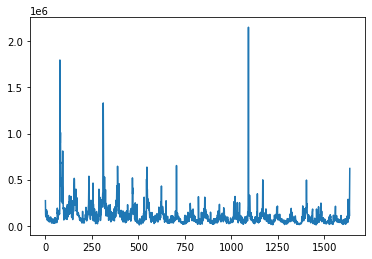

In [139]:
#Lets plot the time series and its ACF plot for the Volume of transactions in the 5 minute Intervals
plt.plot(reset_df["SIZE"])

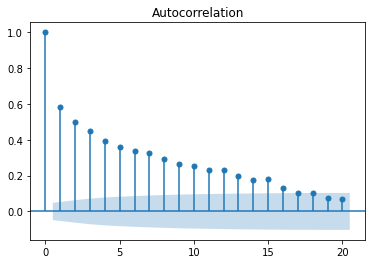

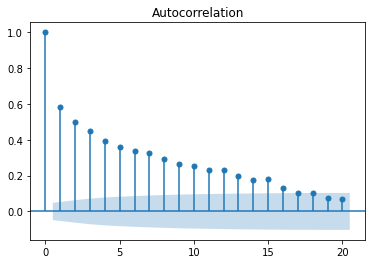

In [141]:
sm.graphics.tsa.plot_acf(reset_df["SIZE"], lags=20)

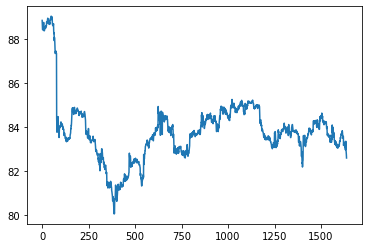

In [142]:
plt.plot(reset_df["PRICE"])

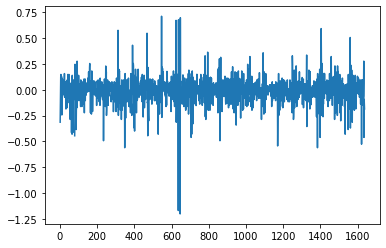

In [153]:
#but in order to get returns, we need to difference the data
returns = np.log((reset_df["PRICE"] - reset_df["PRICE"].shift())+1)
plt.plot(returns)

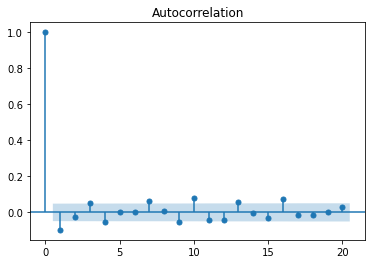

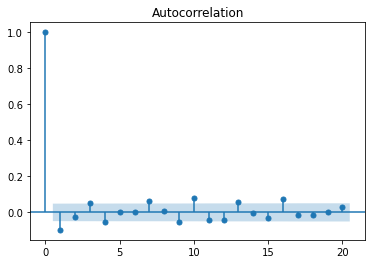

In [154]:
sm.graphics.tsa.plot_acf(returns.dropna(), lags=20)

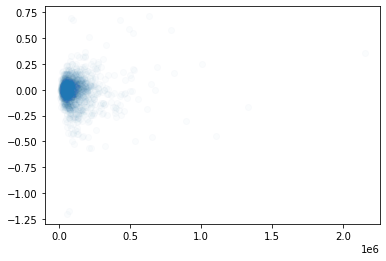

In [155]:
#Now lets plot the series (volume, returns)
plt.scatter(reset_df["SIZE"], returns, alpha = 0.02)

In [ ]:
#Now lets tabulate the relative frequencies of price changes in multiples of tick size $0.0625



